# Notebook 2 : Consommation d'Energie (SiteEnergyUse)

## Contexte
Pour atteindre l'objectif de ville neutre en émissions de carbone en 2050, la ville de Seattle s’intéresse de près aux émissions des bâtiments non destinés à l’habitation.

Des relevés minutieux ont été effectués <strong>en 2016</strong>. Cependant, ces relevés sont coûteux à obtenir, et à partir de ceux déjà réalisés, nous devons tenter de prédire les émissions de CO2 et la consommation totale d’énergie de bâtiments pour lesquels elles n’ont pas encore été mesurées.


--------------------------------------------------------
La première partie nous a permis de réaliser un nettoyage des fichiers et une courte analyse exploratoire (Seattle Notebook Nettoyage ).
Dans cette seconde partie, nous allons réaliser les diverses modélisations grâce à des approches linéaires et non-linéaire afin de prédire <strong>les émissions de CO2 </strong> et <strong>les consommations d'énergie des bâtiments.</strong>

## Sommaire :

- 1° Preprocessing    
    * <strong>1.1. Encodage et standardisation</strong>  
    * <strong>1.2. Préparation des jeux d'entrainement et de test </strong>

- 2° Modèle Baseline : Régression linéaire multivariée 
- 3° Modèle linéaires : ElasticNet et SVR 

    * <strong> 3.1. Modèle ElasticNet </strong>
    * <strong> 3.2. Modèle Support Vector Regression (SVR) </strong>

- 4° Modèle non-linéaires : RandomForestRegressor
    * <strong>4.1. Modèle RandomForestRegressor</strong>

- 5° Sélection des meilleurs modèles
    * 5.1. Modèle de prédiction des émissions de CO2 <strong>[Notebook Emission C02]</strong>
    * <strong>5.2. Modèle de prédiction des consommations d'énergie</strong>

- 6° Test des modèles sélectionnés 
    * 6.1. Prédiction des émissions de CO2
    * 6.2. Prédiction des consommation d'énergie
    
- 7° Influence du score ENERGY STAR

### 1° Preprocessing

In [882]:
import numpy as np
import pandas as pd
import matplotlib
import sklearn
import datetime
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import seaborn as sns
sns.set_style("whitegrid")
sns.color_palette("crest", as_cmap=True)

from scipy import stats
from sklearn.pipeline import Pipeline
from category_encoders import *
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler





In [883]:
# Versions
print('Version des librairies utilisées :')
print('Python                : ' + sys.version)
print('NumPy                 : ' + np.version.full_version)
print('Pandas                : ' + pd.__version__)
print('Matplotlib            : ' + matplotlib.__version__)
print('Seaborn               : ' + sns.__version__)
print('Sklearn               : ' + sklearn.__version__)

now = datetime.datetime.now().isoformat()
print('Lancé le           : ' + now)

Version des librairies utilisées :
Python                : 3.9.12 (main, Apr  4 2022, 05:22:27) [MSC v.1916 64 bit (AMD64)]
NumPy                 : 1.21.5
Pandas                : 1.4.2
Matplotlib            : 3.5.1
Seaborn               : 0.11.2
Sklearn               : 1.0.2
Lancé le           : 2022-10-21T16:49:56.505971


In [884]:
pip install category_encoders

In [885]:
df= pd.read_csv("building-energy-cleaned.csv")

In [886]:
df.shape

(1548, 30)

In [887]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1548 entries, 0 to 1547
Data columns (total 30 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   OSEBuildingID             1548 non-null   int64  
 1   DataYear                  1548 non-null   int64  
 2   BuildingType              1548 non-null   object 
 3   PrimaryPropertyType       1548 non-null   object 
 4   PropertyName              1548 non-null   object 
 5   Address                   1548 non-null   object 
 6   State                     1548 non-null   object 
 7   ZipCode                   1535 non-null   float64
 8   Neighborhood              1548 non-null   object 
 9   NumberofBuildings         1548 non-null   float64
 10  NumberofFloors            1548 non-null   int64  
 11  PropertyGFATotal          1548 non-null   int64  
 12  LargestPropertyUseType    1548 non-null   object 
 13  YearsENERGYSTARCertified  97 non-null     object 
 14  ENERGYST

In [888]:
df.head()

,OSEBuildingID,DataYear,BuildingType,PrimaryPropertyType,PropertyName,Address,State,ZipCode,Neighborhood,NumberofBuildings,...,NaturalGas(kBtu),TotalGHGEmissions,GHGEmissionsIntensity,BuildingAge,TotalUseTypeNumber,GFABuildingRate,GFAParkingRate,GFAPerBuilding,GFAPerFloor,harvesine_distance
0,1,2016,NonResidential,Hotel,Mayflower park hotel,405 Olive way,WA,98101.0,DOWNTOWN,1.0,...,1276453.0,249.98,2.83,89,1,1.00000,0.00000,88434.0,7369.500,0.496782
1,2,2016,NonResidential,Hotel,Paramount Hotel,724 Pine street,WA,98101.0,DOWNTOWN,1.0,...,5145082.0,295.86,2.86,20,3,0.85455,0.14545,103566.0,9415.091,0.488726
2,3,2016,NonResidential,Hotel,5673-The Westin Seattle,1900 5th Avenue,WA,98101.0,DOWNTOWN,1.0,...,1493800.0,2089.28,2.19,47,1,0.79425,0.20575,956110.0,23319.756,0.602378
3,5,2016,NonResidential,Hotel,HOTEL MAX,620 STEWART ST,WA,98101.0,DOWNTOWN,1.0,...,1811213.0,286.43,4.67,90,1,1.00000,0.00000,61320.0,6132.000,0.586253
4,8,2016,NonResidential,Hotel,WARWICK SEATTLE HOTEL (ID8),401 LENORA ST,WA,98121.0,DOWNTOWN,1.0,...,8803998.0,505.01,2.88,36,3,0.64688,0.35312,175580.0,9754.444,0.650801


In [889]:
import dtale.app as dtale_app

dtale_app.USE_COLAB = True 

In [890]:
#Test

In [891]:
#dfd =dtale_app.show(df)
#dfd

In [892]:
df.columns

Index(['OSEBuildingID', 'DataYear', 'BuildingType', 'PrimaryPropertyType',
       'PropertyName', 'Address', 'State', 'ZipCode', 'Neighborhood',
       'NumberofBuildings', 'NumberofFloors', 'PropertyGFATotal',
       'LargestPropertyUseType', 'YearsENERGYSTARCertified', 'ENERGYSTARScore',
       'SiteEUI(kBtu/sf)', 'SourceEUI(kBtu/sf)', 'SiteEnergyUse(kBtu)',
       'SteamUse(kBtu)', 'Electricity(kBtu)', 'NaturalGas(kBtu)',
       'TotalGHGEmissions', 'GHGEmissionsIntensity', 'BuildingAge',
       'TotalUseTypeNumber', 'GFABuildingRate', 'GFAParkingRate',
       'GFAPerBuilding', 'GFAPerFloor', 'harvesine_distance'],
      dtype='object')

In [893]:
df.describe()

,OSEBuildingID,DataYear,ZipCode,NumberofBuildings,NumberofFloors,PropertyGFATotal,ENERGYSTARScore,SiteEUI(kBtu/sf),SourceEUI(kBtu/sf),SiteEnergyUse(kBtu),...,NaturalGas(kBtu),TotalGHGEmissions,GHGEmissionsIntensity,BuildingAge,TotalUseTypeNumber,GFABuildingRate,GFAParkingRate,GFAPerBuilding,GFAPerFloor,harvesine_distance
count,1548.000000,1548.0,1535.000000,1548.000000,1548.000000,1.548000e+03,997.000000,1548.000000,1548.000000,1.548000e+03,...,1.548000e+03,1548.000000,1548.000000,1548.000000,1548.000000,1548.000000,1548.000000,1548.0,1548.00000,1548.000000
mean,16497.944444,2016.0,98116.776547,1.178941,4.276486,1.213321e+05,63.635908,75.084109,183.216667,8.860058e+06,...,2.038297e+06,193.608908,1.667358,54.355943,1.952842,0.934666,0.065334,inf,inf,2.720660
std,13827.877766,0.0,18.695570,3.039221,6.780694,3.062944e+05,28.825309,75.212839,187.966057,3.130568e+07,...,9.710667e+06,779.105278,2.407577,32.886918,1.243355,0.144040,0.144040,NaN,NaN,2.187473
min,1.000000,2016.0,98006.000000,0.000000,0.000000,1.128500e+04,1.000000,1.400000,0.000000,5.713320e+04,...,0.000000e+00,-0.800000,-0.020000,1.000000,1.000000,0.104980,0.000000,4300.0,221.69700,0.021130
25%,602.750000,2016.0,98104.000000,1.000000,1.000000,2.884325e+04,44.000000,34.900002,81.199997,1.251083e+06,...,0.000000e+00,20.655000,0.360000,27.000000,1.000000,1.000000,0.000000,28672.0,12960.00000,0.836309
50%,21180.500000,2016.0,98109.000000,1.000000,2.000000,4.815900e+04,71.000000,53.750000,138.650002,2.732167e+06,...,4.881350e+05,49.845000,0.880000,50.500000,2.000000,1.000000,0.000000,48229.5,22365.35000,2.097849
75%,24609.000000,2016.0,98125.000000,1.000000,4.000000,1.076615e+05,88.000000,85.199997,213.549995,7.294487e+06,...,1.530812e+06,147.227500,1.960000,86.000000,2.000000,1.000000,0.000000,112644.0,37458.47125,4.098127
max,50226.000000,2016.0,98199.000000,111.000000,99.000000,9.320156e+06,100.000000,834.400024,2620.000000,8.739237e+08,...,2.979090e+08,16870.980000,34.090000,116.000000,13.000000,1.000000,0.895020,inf,inf,8.843544


Remarque: 

Dans cette description, on remarque des données avec des valeurs infinies.
- Nous allons regarder de plus prêt ces données et les corriger :

In [894]:
df[(df.GFAPerBuilding == np.inf)  | (df.GFAPerFloor == np.inf)].head()

,OSEBuildingID,DataYear,BuildingType,PrimaryPropertyType,PropertyName,Address,State,ZipCode,Neighborhood,NumberofBuildings,...,NaturalGas(kBtu),TotalGHGEmissions,GHGEmissionsIntensity,BuildingAge,TotalUseTypeNumber,GFABuildingRate,GFAParkingRate,GFAPerBuilding,GFAPerFloor,harvesine_distance
56,89,2016,NonResidential,Medical Office,Polyclinic North && South,1200 Harvard Ave,WA,98122.0,EAST,0.0,...,6814570.0,430.84,2.41,51,1,1.00000,0.00000,inf,59671.333,0.658562
69,113,2016,NonResidential,Small- and Mid-Sized Office,KCTS9,401 Mercer St,WA,98109.0,MAGNOLIA / QUEEN ANNE,0.0,...,0.0,29.04,0.44,30,5,0.96449,0.03551,inf,33120.000,1.438289
126,257,2016,NonResidential,Warehouse,Harbor Island: Warehouse E - DNRP-SWD,3235 16TH AVE SW,WA,98134.0,GREATER DUWAMISH,0.0,...,0.0,16.81,0.21,100,1,1.00000,0.00000,inf,19900.000,2.452644
130,267,2016,NonResidential,Hotel,Grand Hyatt Seattle,721 Pine St,WA,98101.0,DOWNTOWN,1.0,...,25683162.0,1638.46,1.75,17,5,1.00000,0.00000,934292.0,inf,0.455683
152,322,2016,NonResidential,Large Office,Cox Media Group Seattle KIRO TV (322),2801 3rd Ave,WA,98121.0,DOWNTOWN,0.0,...,0.0,68.24,0.68,48,1,0.73464,0.26536,inf,33578.000,1.186739


In [895]:
df['GFAPerBuilding'] = np.where(((df.GFAPerBuilding == np.inf)& (df.NumberofBuildings == 0)),0,df.GFAPerBuilding)
df['GFAPerFloor'] =np.where(((df.GFAPerFloor == np.inf)&(df.NumberofFloors == 0)),0,df.GFAPerFloor)

In [896]:
df.describe()

,OSEBuildingID,DataYear,ZipCode,NumberofBuildings,NumberofFloors,PropertyGFATotal,ENERGYSTARScore,SiteEUI(kBtu/sf),SourceEUI(kBtu/sf),SiteEnergyUse(kBtu),...,NaturalGas(kBtu),TotalGHGEmissions,GHGEmissionsIntensity,BuildingAge,TotalUseTypeNumber,GFABuildingRate,GFAParkingRate,GFAPerBuilding,GFAPerFloor,harvesine_distance
count,1548.000000,1548.0,1535.000000,1548.000000,1548.000000,1.548000e+03,997.000000,1548.000000,1548.000000,1.548000e+03,...,1.548000e+03,1548.000000,1548.000000,1548.000000,1548.000000,1548.000000,1548.000000,1.548000e+03,1.548000e+03,1548.000000
mean,16497.944444,2016.0,98116.776547,1.178941,4.276486,1.213321e+05,63.635908,75.084109,183.216667,8.860058e+06,...,2.038297e+06,193.608908,1.667358,54.355943,1.952842,0.934666,0.065334,1.051305e+05,3.295643e+04,2.720660
std,13827.877766,0.0,18.695570,3.039221,6.780694,3.062944e+05,28.825309,75.212839,187.966057,3.130568e+07,...,9.710667e+06,779.105278,2.407577,32.886918,1.243355,0.144040,0.144040,1.851890e+05,4.846973e+04,2.187473
min,1.000000,2016.0,98006.000000,0.000000,0.000000,1.128500e+04,1.000000,1.400000,0.000000,5.713320e+04,...,0.000000e+00,-0.800000,-0.020000,1.000000,1.000000,0.104980,0.000000,0.000000e+00,0.000000e+00,0.021130
25%,602.750000,2016.0,98104.000000,1.000000,1.000000,2.884325e+04,44.000000,34.900002,81.199997,1.251083e+06,...,0.000000e+00,20.655000,0.360000,27.000000,1.000000,1.000000,0.000000,2.680350e+04,1.283884e+04,0.836309
50%,21180.500000,2016.0,98109.000000,1.000000,2.000000,4.815900e+04,71.000000,53.750000,138.650002,2.732167e+06,...,4.881350e+05,49.845000,0.880000,50.500000,2.000000,1.000000,0.000000,4.474700e+04,2.204650e+04,2.097849
75%,24609.000000,2016.0,98125.000000,1.000000,4.000000,1.076615e+05,88.000000,85.199997,213.549995,7.294487e+06,...,1.530812e+06,147.227500,1.960000,86.000000,2.000000,1.000000,0.000000,9.847625e+04,3.601000e+04,4.098127
max,50226.000000,2016.0,98199.000000,111.000000,99.000000,9.320156e+06,100.000000,834.400024,2620.000000,8.739237e+08,...,2.979090e+08,16870.980000,34.090000,116.000000,13.000000,1.000000,0.895020,2.200000e+06,1.100000e+06,8.843544


Remarque: 

Comme vue précédemment "Les Campus" sont les types de construction qui consomme le plus ! Nous allons vérifier la distribution des consommations en fonction des surfaces totales au sol par catégorie de bâtiment.Et voir si valeurs abérrantes ou anormal apparaissent: 

In [897]:
%matplotlib inline
import matplotlib.pyplot as plt

In [898]:
#import tkinter
#import matplotlib
#import matplotlib.pyplot as plt
#matplotlib.use('TkAgg')

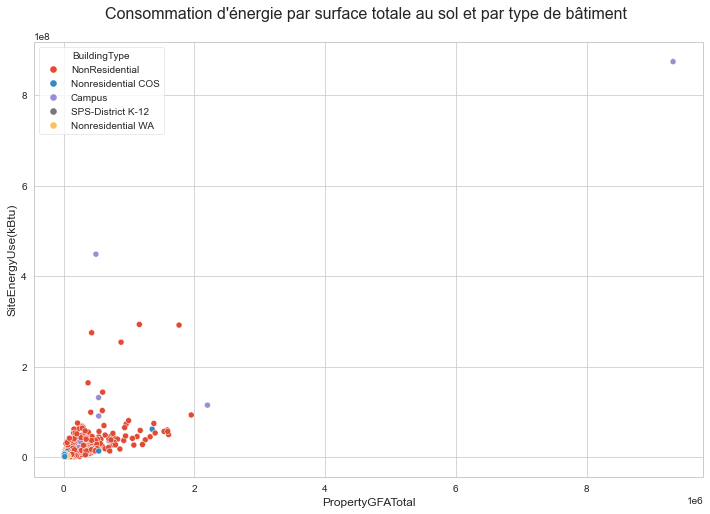

In [899]:
font_title = { 'family' :'serif',
                'color': 'red',
                'weight':'bold',
                'size': 18,}

fig = plt.figure(figsize=(12 ,8))
sns.scatterplot(data=df, x='PropertyGFATotal', y='SiteEnergyUse(kBtu)',hue="BuildingType")

plt.title(f"Consommation d'énergie par surface totale au sol et par type de bâtiment \n",fontsize=16)

plt.show()

Remarque: 

 - Nous avons ici ,une donnée très sup aux autres => Ici, il ne s'agit visiblement que d'une valeur atypique très isolée. 

 - Nous pourrons supprimer ici ces valeurs atypiques de nos données : 

In [900]:
df[df['SiteEnergyUse(kBtu)']>8*10**8]

,OSEBuildingID,DataYear,BuildingType,PrimaryPropertyType,PropertyName,Address,State,ZipCode,Neighborhood,NumberofBuildings,...,NaturalGas(kBtu),TotalGHGEmissions,GHGEmissionsIntensity,BuildingAge,TotalUseTypeNumber,GFABuildingRate,GFAParkingRate,GFAPerBuilding,GFAPerFloor,harvesine_distance
1510,49967,2016,Campus,University,University of Washington - Seattle Campus,NE 45th St & Brooklyn Ave,WA,98105.0,NORTHEAST,111.0,...,0.0,11140.56,1.2,116,1,1.0,0.0,83965.369,0.0,3.612662


In [901]:
df=df[df['SiteEnergyUse(kBtu)']<8*10**8]

In [902]:
df[df['TotalGHGEmissions']<0]

,OSEBuildingID,DataYear,BuildingType,PrimaryPropertyType,PropertyName,Address,State,ZipCode,Neighborhood,NumberofBuildings,...,NaturalGas(kBtu),TotalGHGEmissions,GHGEmissionsIntensity,BuildingAge,TotalUseTypeNumber,GFABuildingRate,GFAParkingRate,GFAPerBuilding,GFAPerFloor,harvesine_distance
1488,49784,2016,NonResidential,Small- and Mid-Sized Office,Bullitt Center,1501 E. Madison St.,WA,98122.0,CENTRAL,1.0,...,0.0,-0.8,-0.02,3,1,1.0,0.0,52000.0,8666.667,1.068066


In [903]:
df.shape

(1547, 30)

In [904]:
df=df[df['TotalGHGEmissions']>0]

In [905]:
df.shape

(1545, 30)

Nous allons regrouper les données d'identification des bâtiments afin qu'elle ne pertubent pas nos modélisations mais reste utilisable. 

Et supprimer les variables ("'SteamUse(kBtu)" | "Electricity(kBtu)"|"NaturalGas(kBtu)") :

In [906]:
identification_features=['OSEBuildingID','PropertyName','Address','ZipCode']

df_identification = df[identification_features]

df2 = df.drop(identification_features,axis=1)

In [907]:
df2.columns

Index(['DataYear', 'BuildingType', 'PrimaryPropertyType', 'State',
       'Neighborhood', 'NumberofBuildings', 'NumberofFloors',
       'PropertyGFATotal', 'LargestPropertyUseType',
       'YearsENERGYSTARCertified', 'ENERGYSTARScore', 'SiteEUI(kBtu/sf)',
       'SourceEUI(kBtu/sf)', 'SiteEnergyUse(kBtu)', 'SteamUse(kBtu)',
       'Electricity(kBtu)', 'NaturalGas(kBtu)', 'TotalGHGEmissions',
       'GHGEmissionsIntensity', 'BuildingAge', 'TotalUseTypeNumber',
       'GFABuildingRate', 'GFAParkingRate', 'GFAPerBuilding', 'GFAPerFloor',
       'harvesine_distance'],
      dtype='object')

In [908]:
df3 = df2.drop(['SteamUse(kBtu)','Electricity(kBtu)',
                         'NaturalGas(kBtu)'],axis=1)

In [909]:
df3.columns

Index(['DataYear', 'BuildingType', 'PrimaryPropertyType', 'State',
       'Neighborhood', 'NumberofBuildings', 'NumberofFloors',
       'PropertyGFATotal', 'LargestPropertyUseType',
       'YearsENERGYSTARCertified', 'ENERGYSTARScore', 'SiteEUI(kBtu/sf)',
       'SourceEUI(kBtu/sf)', 'SiteEnergyUse(kBtu)', 'TotalGHGEmissions',
       'GHGEmissionsIntensity', 'BuildingAge', 'TotalUseTypeNumber',
       'GFABuildingRate', 'GFAParkingRate', 'GFAPerBuilding', 'GFAPerFloor',
       'harvesine_distance'],
      dtype='object')

In [910]:
df3.head()

,DataYear,BuildingType,PrimaryPropertyType,State,Neighborhood,NumberofBuildings,NumberofFloors,PropertyGFATotal,LargestPropertyUseType,YearsENERGYSTARCertified,...,SiteEnergyUse(kBtu),TotalGHGEmissions,GHGEmissionsIntensity,BuildingAge,TotalUseTypeNumber,GFABuildingRate,GFAParkingRate,GFAPerBuilding,GFAPerFloor,harvesine_distance
0,2016,NonResidential,Hotel,WA,DOWNTOWN,1.0,12,88434,Hotel,NaN,...,7226362.5,249.98,2.83,89,1,1.00000,0.00000,88434.0,7369.500,0.496782
1,2016,NonResidential,Hotel,WA,DOWNTOWN,1.0,11,103566,Hotel,NaN,...,8387933.0,295.86,2.86,20,3,0.85455,0.14545,103566.0,9415.091,0.488726
2,2016,NonResidential,Hotel,WA,DOWNTOWN,1.0,41,956110,Hotel,NaN,...,72587024.0,2089.28,2.19,47,1,0.79425,0.20575,956110.0,23319.756,0.602378
3,2016,NonResidential,Hotel,WA,DOWNTOWN,1.0,10,61320,Hotel,NaN,...,6794584.0,286.43,4.67,90,1,1.00000,0.00000,61320.0,6132.000,0.586253
4,2016,NonResidential,Hotel,WA,DOWNTOWN,1.0,18,175580,Hotel,NaN,...,14172606.0,505.01,2.88,36,3,0.64688,0.35312,175580.0,9754.444,0.650801


In [911]:
df3.describe()

,DataYear,NumberofBuildings,NumberofFloors,PropertyGFATotal,ENERGYSTARScore,SiteEUI(kBtu/sf),SourceEUI(kBtu/sf),SiteEnergyUse(kBtu),TotalGHGEmissions,GHGEmissionsIntensity,BuildingAge,TotalUseTypeNumber,GFABuildingRate,GFAParkingRate,GFAPerBuilding,GFAPerFloor,harvesine_distance
count,1545.0,1545.000000,1545.000000,1.545000e+03,995.000000,1545.000000,1545.000000,1.545000e+03,1545.000000,1545.000000,1545.000000,1545.000000,1545.000000,1545.000000,1.545000e+03,1.545000e+03,1545.000000
mean,2016.0,1.108091,4.280259,1.154646e+05,63.632161,75.029450,183.411521,8.303287e+06,186.774647,1.669832,54.379288,1.952104,0.934539,0.065461,1.052097e+05,3.297781e+04,2.720970
std,0.0,1.199349,6.785750,1.978729e+05,28.812643,75.187493,188.027224,2.229149e+07,728.337240,2.409128,32.834269,1.241671,0.144151,0.144151,1.853590e+05,4.850169e+04,2.189064
min,2016.0,0.000000,0.000000,1.128500e+04,1.000000,1.400000,0.000000,5.713320e+04,0.400000,0.010000,1.000000,1.000000,0.104980,0.000000,0.000000e+00,0.000000e+00,0.021130
25%,2016.0,1.000000,1.000000,2.884100e+04,44.000000,34.900002,81.400002,1.252324e+06,20.760000,0.360000,27.000000,1.000000,1.000000,0.000000,2.669400e+04,1.284750e+04,0.833517
50%,2016.0,1.000000,2.000000,4.811200e+04,71.000000,53.700001,138.699997,2.729168e+06,49.900000,0.880000,51.000000,2.000000,1.000000,0.000000,4.471900e+04,2.204700e+04,2.097496
75%,2016.0,1.000000,4.000000,1.075720e+05,88.000000,85.099998,213.399994,7.273156e+06,147.140000,1.960000,86.000000,2.000000,1.000000,0.000000,9.848000e+04,3.600000e+04,4.099345
max,2016.0,27.000000,99.000000,2.200000e+06,100.000000,834.400024,2620.000000,4.483853e+08,16870.980000,34.090000,116.000000,13.000000,1.000000,0.895020,2.200000e+06,1.100000e+06,8.843544


In [912]:
#Valeur manquante
df3.isna().sum()

DataYear                       0
BuildingType                   0
PrimaryPropertyType            0
State                          0
Neighborhood                   0
NumberofBuildings              0
NumberofFloors                 0
PropertyGFATotal               0
LargestPropertyUseType         0
YearsENERGYSTARCertified    1448
ENERGYSTARScore              550
SiteEUI(kBtu/sf)               0
SourceEUI(kBtu/sf)             0
SiteEnergyUse(kBtu)            0
TotalGHGEmissions              0
GHGEmissionsIntensity          0
BuildingAge                    0
TotalUseTypeNumber             0
GFABuildingRate                0
GFAParkingRate                 0
GFAPerBuilding                 0
GFAPerFloor                    0
harvesine_distance             0
dtype: int64

* 1.1. Encodage et standardisation

Ici ,nous allons séparer les données numériques et les données catégorielles
de notre dataset :

In [913]:
numerical_features = df3.select_dtypes(include=['int64','float64'])

categorical_features = df3.select_dtypes(exclude=['int64','float64'])

Pour les données catégorielles: 

 - => nous allons devoir encoder les valeurs. Nous allons donc supprimer les variables qui n'apporteront rien à notre modèle ( par exemple: les constantes) et séparer les variables pouvant être encodées en OneHot des autres.

In [914]:
categorical_features.nunique()

BuildingType                 5
PrimaryPropertyType         21
State                        1
Neighborhood                19
LargestPropertyUseType      56
YearsENERGYSTARCertified    64
dtype: int64

In [915]:
categorical_features = categorical_features.drop(['State','YearsENERGYSTARCertified'],axis=1)

In [916]:
categorical_features.nunique()

BuildingType               5
PrimaryPropertyType       21
Neighborhood              19
LargestPropertyUseType    56
dtype: int64

Pour toutes ces variables, nous pourrons utiliser la méthode "TagetEncoder" de la librairie Category_Encoders que nous intégrerons dans un pipeline Sklearn.
Cet encodeur réalise 2 principales étapes :

- Groupe les données par chaque catégorie et compte de nombre d'occurrences de chaque cible.

- Calcul de la probabilité que chaque cible se produise pour chaque groupe spécifique.

In [917]:
#Données de type numériques:

list(numerical_features.columns)

['DataYear',
 'NumberofBuildings',
 'NumberofFloors',
 'PropertyGFATotal',
 'ENERGYSTARScore',
 'SiteEUI(kBtu/sf)',
 'SourceEUI(kBtu/sf)',
 'SiteEnergyUse(kBtu)',
 'TotalGHGEmissions',
 'GHGEmissionsIntensity',
 'BuildingAge',
 'TotalUseTypeNumber',
 'GFABuildingRate',
 'GFAParkingRate',
 'GFAPerBuilding',
 'GFAPerFloor',
 'harvesine_distance']

Remarque: 

- La date de relevé ne nous sera pas utile ici, nous la supprimerons du jeu de données. 

- ENERGYSTARScore est insuffisement complété. Nous allons l'écarter du jeu de donnée(pour l'instant ) mais nous la conservons pour vérifier ensuite si cette variable a un impact sur la qualité de prédiction.

In [918]:
energystar_score = numerical_features['ENERGYSTARScore']

numerical_features = numerical_features.drop(['ENERGYSTARScore','DataYear'], axis=1)

In [919]:
list(numerical_features.columns)

['NumberofBuildings',
 'NumberofFloors',
 'PropertyGFATotal',
 'SiteEUI(kBtu/sf)',
 'SourceEUI(kBtu/sf)',
 'SiteEnergyUse(kBtu)',
 'TotalGHGEmissions',
 'GHGEmissionsIntensity',
 'BuildingAge',
 'TotalUseTypeNumber',
 'GFABuildingRate',
 'GFAParkingRate',
 'GFAPerBuilding',
 'GFAPerFloor',
 'harvesine_distance']

Ici les données numériques devront être standardisée pour entrer dans nos modèles de prédictions .

Pour cela, nous réaliserons un "centrage-réduction" via la méthode : "StandardScaler de Scikit-Learn."

In [920]:
df3 = pd.concat([categorical_features, numerical_features], axis=1)

In [921]:
#Préparation du Preprocessor : 

from sklearn.preprocessing import StandardScaler, OrdinalEncoder, RobustScaler
from category_encoders.target_encoder import TargetEncoder
from sklearn.compose import ColumnTransformer

target_features = ['BuildingType','PrimaryPropertyType','Neighborhood','LargestPropertyUseType']
target_transformer = TargetEncoder()

numeric_features = ['harvesine_distance','NumberofBuildings','NumberofFloors',
                    'PropertyGFATotal','BuildingAge','TotalUseTypeNumber',
                    'GFABuildingRate','GFAParkingRate','GFAPerBuilding','GFAPerFloor']
numeric_transformer = RobustScaler(unit_variance=True)

preprocessor = ColumnTransformer(transformers=[
    ('target', target_transformer, target_features),
    ('numeric', numeric_transformer, numeric_features)
])

Default parameter min_samples_leaf will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327
Default parameter smoothing will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327


In [922]:
import warnings
def get_feature_names(column_transformer):
    """Get feature names from all transformers.
    Returns
    -------
    feature_names : list of strings
        Names of the features produced by transform.
        
    ------
    Code from :
        https://johaupt.github.io/
    """
    # Remove the internal helper function
    #check_is_fitted(column_transformer)
    
    # Turn loopkup into function for better handling with pipeline later
    def get_names(trans):
        # >> Original get_feature_names() method
        if trans == 'drop' or (
                hasattr(column, '__len__') and not len(column)):
            return []
        if trans == 'passthrough':
            if hasattr(column_transformer, '_df_columns'):
                if ((not isinstance(column, slice))
                        and all(isinstance(col, str) for col in column)):
                    return column
                else:
                    return column_transformer._df_columns[column]
            else:
                indices = np.arange(column_transformer._n_features)
                return ['x%d' % i for i in indices[column]]
        if not hasattr(trans, 'get_feature_names'):
        # >>> Change: Return input column names if no method avaiable
            # Turn error into a warning
            warnings.warn("Transformer %s (type %s) does not "
                                 "provide get_feature_names. "
                                 "Will return input column names if available"
                                 % (str(name), type(trans).__name__))
            # For transformers without a get_features_names method, use the input
            # names to the column transformer
            if column is None:
                return []
            else:
                return [f for f in column]

        return [f for f in trans.get_feature_names()]
    
    ### Start of processing
    feature_names = []
    
    l_transformers = list(column_transformer._iter(fitted=True))
    
    
    for name, trans, column, _ in l_transformers: 
        feature_names.extend(get_names(trans))
    
    return feature_names

1.2. Préparation des jeux d'entrainement et de test

Afin de tester notre meilleur modèle sur des données "inconnues", nous allons mettre de côté une partie des données.

=>  Nous allons donc spliter nos données pour obtenir un jeu d'entrainement (80% des données) et un jeu de test (20% des données)

In [923]:
from sklearn.model_selection import train_test_split

X = df3.drop(['TotalGHGEmissions','SiteEnergyUse(kBtu)'], axis=1)
Y = df3[['TotalGHGEmissions','SiteEnergyUse(kBtu)']]

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

print("Entrainement: {} lignes,\nTest: {} lignes.\n".format(X_train.shape[0],
                                                            X_test.shape[0]))

Entrainement: 1236 lignes,
Test: 309 lignes.



Concernant nos variables à prédire, nous allons regarder l'impact du passage à l'échelle logarithmique sur les distribution :

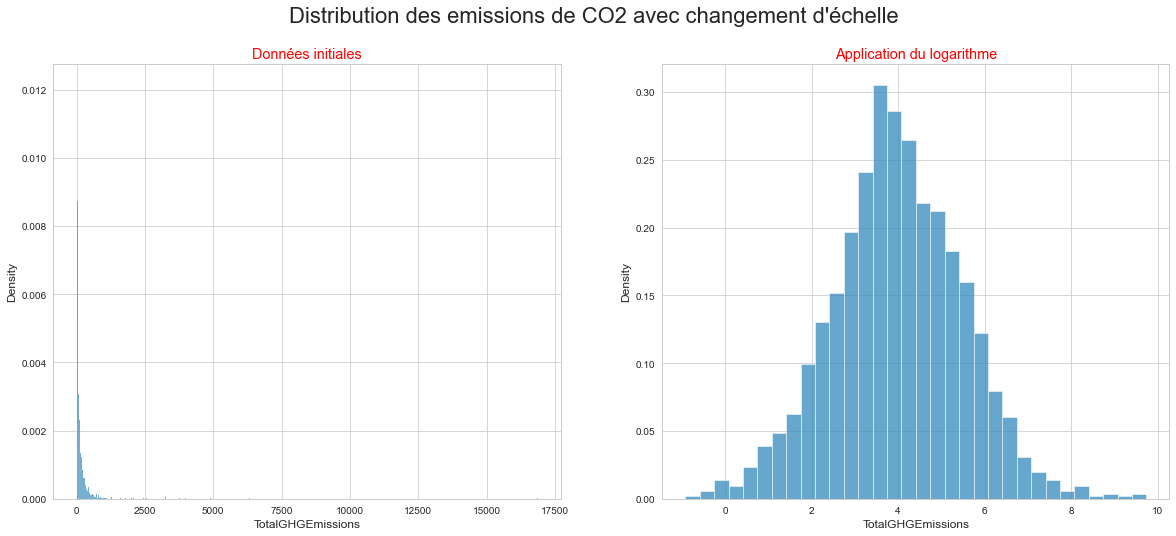

In [924]:
from sklearn.preprocessing import FunctionTransformer

# voir : fait décallage de l'ensemble des valeurs en ajoutant un min | 

logtransformer = FunctionTransformer(np.log, inverse_func = np.exp, check_inverse = True)
Y_log = logtransformer.transform(Y)

fig, axes = plt.subplots(nrows=1, ncols=2, sharex=False, sharey=False, figsize=(20,8))
sns.histplot(data=Y, x='TotalGHGEmissions', stat="density", ax=axes[0])
axes[0].set_title("Données initiales", color='red')
sns.histplot(data=Y_log, x='TotalGHGEmissions', stat="density", ax=axes[1])
axes[1].set_title("Application du logarithme", color='red')
plt.suptitle("Distribution des emissions de CO2 avec changement d'échelle", fontsize=22)
plt.show()

Remarque :

En passant les données à l'échelle logarithmique:

-  nous obtenons une distribution normale des données à prédire.
-  nous allons donc appliquer cette transformation dans notre pipeline grâce à la fonction TransformedTargetRegressor de la librairie Sklearn.

### 2. Modèle Baseline : Régression linéaire multivariée

A présent, nous allons créer un modèle baseline pour évaluer les performances de nos futurs modèles et vérifier qu'ils améliore les prédictions. Pour cette baseline, nous utiliserons une régression linéaire multivariée.

Note : Paramètres LinearRegression : 

- "fit_intercept booléen , par défaut=Vrai":

    S'il faut calculer l'ordonnée à l'origine pour ce modèle. S'il est défini sur False, aucune interception ne sera utilisée dans les calculs (c'est-à-dire que les données doivent être centrées).

- "normaliser booléen, défaut=Faux":

    Ce paramètre est ignoré lorsqu'il fit_interceptest défini sur False. Si True, les régresseurs X seront normalisés avant la régression en soustrayant la moyenne et en divisant par la norme l2. Si vous souhaitez normaliser, veuillez utiliser StandardScaleravant de faire appel fit à un estimateur avec normalize=False.

In [925]:
from sklearn.compose import TransformedTargetRegressor
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn import set_config
set_config(display='diagram')


param_mlr = {"regressor__fit_intercept": [True, False],  # à verifier le doc pour les hyperparamètres
             "regressor__normalize": [True, False]} # à verifier le doc pour les hyperparamètres

mlr_grid_cv = Pipeline([
    ('preprocessor', preprocessor),
    ('grid_search_mlr', GridSearchCV(
                            TransformedTargetRegressor(
                                regressor=LinearRegression(), 
                                func=np.log, 
                                inverse_func=np.exp),
                            param_grid=param_mlr,
                            cv=5,
                            scoring=('r2','neg_mean_absolute_error'),
                            return_train_score = True,
                            refit='neg_mean_absolute_error',
                            n_jobs = -1))])

Nous pouvons calculer 2 principales métriques pour évaluer nos modèles :

- MAE : Mean Absolute Error.
- R² : Coeficient de détermination, carré du coefiscient de corrélation linéaire.

- note : 
  * MAE: En statistique , l'erreur absolue moyenne ( EMA ) est une mesure des erreurs entre des observations appariées exprimant le même phénomène || L'erreur absolue moyenne est l'une des nombreuses façons de comparer les prévisions avec leurs résultats éventuels | 
  
  Comment calculez-vous l'erreur absolue moyenne dans MAE?
  * L'erreur absolue moyenne (MAE) est calculée en additionnant la différence absolue entre les valeurs réelles et calculées de chaque observation sur l'ensemble du tableau, puis en divisant la somme obtenue par le nombre d'observations dans le tableau.

  * R² : Ce coefficient varie entre 0 et 1, soit entre un pouvoir de prédiction faible et un pouvoir de prédiction fort. Le coefficient de détermination (R², soit le carré du coefficient de corrélation linéaire r) est un indicateur qui permet de juger la qualité d'une régression linéaire simple.

In [926]:
#Retour des meilleurs scores NMAE et R2
#Stockage du dataframe de resultats du modèle
def model_scores(pip,step):
    df_results = pd.DataFrame.from_dict(pip.named_steps[step].cv_results_) \
                    .sort_values('rank_test_neg_mean_absolute_error')
    best_nmae = pip.named_steps[step].best_score_
    best_r2 = np.mean(df_results[df_results.rank_test_r2 == 1]['mean_test_r2'])
    best_params = pip.named_steps[step].best_params_
    training_time = round((np.mean(df_results.mean_fit_time)*X_train.shape[0]),2)

    
    print("Meilleur score MAE : {}\nMeilleur Score R2 : {}\nMeilleurs paramètres : {}\nTemps moyen d'entrainement : {}s"\
         .format(round(best_nmae,3), round(best_r2,3), best_params, training_time))
    return df_results

On affiche les scores de la GridSearch avec validation croisée pour la variable <strong>SiteEnergyUse(kBtu)</strong> :

In [927]:
#les scores pour la variable SiteEnergyUse(kBtu) :

SEU_mlr_model = mlr_grid_cv.fit(X_train, Y_train['SiteEnergyUse(kBtu)'])
SEU_mlr_results = model_scores(SEU_mlr_model, 'grid_search_mlr')

Default parameter min_samples_leaf will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327
Default parameter smoothing will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327


Meilleur score MAE : -63168003.957
Meilleur Score R2 : -2516.01
Meilleurs paramètres : {'regressor__fit_intercept': True, 'regressor__normalize': True}
Temps moyen d'entrainement : 18.79s


'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LinearRegression())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)




Tous les résultats des GridSearchCV sont stockés dans un DataFrame pour chaque variable à prédire : MAE | MSE | RMSE 

- L'erreur absolue moyenne calcule ainsi la valeur absolue de ces erreurs, pour en faire la moyenne. En anglais, on l'appelle "Mean Absolute Error" (MAE)

- De son coté, l'erreur quadratique moyenne calcule le carré des erreurs résiduelles, pour en faire la moyenne. En anglais, on l'appelle "Mean Squared Error" (MSE)


Note : "MSE -> vous accordez une grande importance aux grandes erreurs !
MAE -> l'importance d'une erreur est linéaire avec son amplitude.Si le Dataset des valeurs aberrantes(outliers)."

In [928]:
SEU_mlr_results

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_regressor__fit_intercept,param_regressor__normalize,params,split0_test_r2,split1_test_r2,split2_test_r2,...,mean_test_neg_mean_absolute_error,std_test_neg_mean_absolute_error,rank_test_neg_mean_absolute_error,split0_train_neg_mean_absolute_error,split1_train_neg_mean_absolute_error,split2_train_neg_mean_absolute_error,split3_train_neg_mean_absolute_error,split4_train_neg_mean_absolute_error,mean_train_neg_mean_absolute_error,std_train_neg_mean_absolute_error
0,0.040406,0.037842,0.002400,0.000488,True,True,"{'regressor__fit_intercept': True, 'regressor_...",-8.212681e-01,-3.278781e+00,-1.248829e+04,...,-6.316800e+07,1.077460e+08,1,-9.369040e+06,-1.017253e+07,-1.379413e+07,-9.845825e+06,-1.013647e+07,-1.066360e+07,1.591468e+06
1,0.012602,0.008166,0.001400,0.000489,True,False,"{'regressor__fit_intercept': True, 'regressor_...",-8.212681e-01,-3.278781e+00,-1.248829e+04,...,-6.316800e+07,1.077460e+08,2,-9.369040e+06,-1.017253e+07,-1.379413e+07,-9.845825e+06,-1.013647e+07,-1.066360e+07,1.591468e+06
2,0.004597,0.000799,0.001398,0.000492,False,True,"{'regressor__fit_intercept': False, 'regressor...",-5.054464e+14,-1.876971e+09,-6.274175e+14,...,-3.248347e+13,2.917079e+13,3,-1.805023e+13,-1.061635e+13,-2.279294e+13,-2.198017e+13,-1.177450e+13,-1.704284e+13,5.049969e+12
3,0.003200,0.000400,0.001800,0.000401,False,False,"{'regressor__fit_intercept': False, 'regressor...",-5.054464e+14,-1.876971e+09,-6.274175e+14,...,-3.248347e+13,2.917079e+13,3,-1.805023e+13,-1.061635e+13,-2.279294e+13,-2.198017e+13,-1.177450e+13,-1.704284e+13,5.049969e+12


Nous avons à présent nos métriques de départ obtenues avec notre modèle de régression linéaire multivarié servant de baseline.

Nous pouvons réaliser nos premières modélisations en utilisant des modèles linéaires

DUMMY REGRESSOR 

In [929]:
# D1 TEST


# def define_preprocessor(X):
# 
#     # Load libraries
#     from sklearn.pipeline import Pipeline
#     from sklearn.preprocessing import StandardScaler
#     from category_encoders.target_encoder import TargetEncoder
#     from sklearn.preprocessing import LabelEncoder
#     from sklearn.compose import ColumnTransformer
#     from sklearn.impute import SimpleImputer
#     from sklearn.experimental import enable_iterative_imputer
#     from sklearn.impute import IterativeImpute
# 
# 
# 
# from sklearn import dummy
# 
# from sklearn import linear_model
# from sklearn.ensemble import AdaBoostRegressor
# from sklearn.svm import SVR
# from sklearn.ensemble import RandomForestRegressor
# from sklearn.neighbors import KNeighborsRegressor
# 
# dum = Pipeline(steps=[('prepa',preprocessor),('dum',dummy.DummyRegressor(strategy='mean'))])
# 
# 
# forest = Pipeline(steps=[('prepa',preprocessor),('forest',RandomForestRegressor(random_state=0))])
# linear = Pipeline(steps=[('prepa',preprocessor),('linear',linear_model.LinearRegression())])
# KNN = Pipeline(steps=[('prepa',preprocessor),('kNN',KNeighborsRegressor())])
# ADA = Pipeline(steps=[('prepa',preprocessor),('ADA',AdaBoostRegressor(random_state=0,))])

In [930]:
#D1 TEST

from sklearn.dummy import DummyRegressor
from tempfile import mkdtemp

# Create temp directory for caching transformers: avoid repeated computation
cachedir = mkdtemp()

# def define_pipeline(preprocessor, regressor):
# 
#     # Load libraries
#     from sklearn.pipeline import Pipeline
# 
#     # Create a pipeline
#     pipe = Pipeline([("preprocess", preprocessor), # preprocessing steps
#                      ("regressor", regressor), # dummy regression model
#                     ],
#                     memory=cachedir,
#     )
#     
#     # Return pipeline
#     return pipe
# 
# pipe = define_pipeline(preprocessor, DummyRegressor())


In [931]:
#DummyRegressor Baseline :
dfr = df3

In [932]:
#DummyRegressor Baseline :
dfr.tail()

,BuildingType,PrimaryPropertyType,Neighborhood,LargestPropertyUseType,NumberofBuildings,NumberofFloors,PropertyGFATotal,SiteEUI(kBtu/sf),SourceEUI(kBtu/sf),SiteEnergyUse(kBtu),TotalGHGEmissions,GHGEmissionsIntensity,BuildingAge,TotalUseTypeNumber,GFABuildingRate,GFAParkingRate,GFAPerBuilding,GFAPerFloor,harvesine_distance
1543,Nonresidential COS,Other,DELRIDGE NEIGHBORHOODS,Other - Recreation,1.0,1,18261,51.000000,126.000000,9.320821e+05,20.33,1.11,34,1,1.0,0.0,18261.0,18261.0,4.935141
1544,Nonresidential COS,Other,DOWNTOWN,Other - Recreation,1.0,1,16000,59.400002,114.199997,9.502762e+05,32.17,2.01,12,1,1.0,0.0,16000.0,16000.0,0.811312
1545,Nonresidential COS,Other,MAGNOLIA / QUEEN ANNE,Other - Recreation,1.0,1,13157,438.200012,744.799988,5.765898e+06,223.54,16.99,42,3,1.0,0.0,13157.0,13157.0,2.407156
1546,Nonresidential COS,Mixed Use Property,GREATER DUWAMISH,Other - Recreation,1.0,1,14101,51.000000,105.300003,7.194712e+05,22.11,1.57,27,5,1.0,0.0,14101.0,14101.0,5.389475
1547,Nonresidential COS,Mixed Use Property,GREATER DUWAMISH,Other - Recreation,1.0,1,18258,63.099998,115.800003,1.152896e+06,41.27,2.26,78,5,1.0,0.0,18258.0,18258.0,4.920149


In [933]:
#DummyRegressor Baseline :
dfr.dtypes

BuildingType               object
PrimaryPropertyType        object
Neighborhood               object
LargestPropertyUseType     object
NumberofBuildings         float64
NumberofFloors              int64
PropertyGFATotal            int64
SiteEUI(kBtu/sf)          float64
SourceEUI(kBtu/sf)        float64
SiteEnergyUse(kBtu)       float64
TotalGHGEmissions         float64
GHGEmissionsIntensity     float64
BuildingAge                 int64
TotalUseTypeNumber          int64
GFABuildingRate           float64
GFAParkingRate            float64
GFAPerBuilding            float64
GFAPerFloor               float64
harvesine_distance        float64
dtype: object

In [934]:
#DummyRegressor Baseline :
from sklearn.model_selection import train_test_split

X1 = dfr.drop(['TotalGHGEmissions','SiteEnergyUse(kBtu)'], axis=1)
y = dfr[['TotalGHGEmissions']]

X1_train, X1_test, y1_train, y1_test = train_test_split(X1, y, test_size=0.2, random_state=42)

print("Entrainement: {} lignes,\nTest: {} lignes.\n".format(X_train.shape[0],
                                                            X_test.shape[0]))

Entrainement: 1236 lignes,
Test: 309 lignes.



In [935]:
#DummyRegressor Baseline :
from sklearn import model_selection

#X_train,X_test,y_train,y_test = model_selection.train_test_split(X1,y,test_size=0.3)#30% des jeu de test

In [936]:
#DummyRegressor Baseline : Standardisons les données
from sklearn import preprocessing 
from sklearn import neighbors,metrics 
#std_scale=preprocessing.StandardScaler().fit(X_train)
#X_train_std=std_scale.transform(X_train)
#X_test_std=std_scale.transform(X_test)

DUMMYREGRESSOR

In [937]:
#DummyRegressor Baseline : 
from sklearn.metrics import mean_squared_error, r2_score, median_absolute_error
from sklearn import dummy 
dum = dummy.DummyRegressor(strategy='mean')

#Entrainement 
dum.fit(X1_train,y1_train)

#Prédiction sur le jeu test
y1_pred_dum = dum.predict(X1_test)

#Evaluate
print("RMSE : {:.2f}".format(np.sqrt(metrics.mean_squared_error(y1_test,y1_pred_dum)) ))
print("r2_score (dummy mean): {:.2f}".format(r2_score(y1_test, y1_pred_dum)))

RMSE : 1034.67
r2_score (dummy mean): -0.00


### 3. Modèle linéaires : ElasticNet et SVR

Note : 

- Elastic net : 
    
    * La régularisation de type <STRONG>"Elastic net"</strong> consiste à combiner les deux régularisations précédentes (Ridge et Lasso) afin d’éviter la sélectivité trop forte que peut proposer Lasso tout en conservant possiblement des variables fortement corrélées.

    * SVM est un algorithme d'apprentissage supervisé qui essaie de prédire des valeurs basées sur la classification ou la régression en analysant les données et en reconnaissant des modèles. L'algorithme utilisé pour la classification est appelé SVC (Support Vector Classifier) ​​et pour la Régression est appelé <STRONG>SVR (Support Vector Regression)</STRONG>.

   En résumé : 
Elastic Net incorpore des pénalités de régularisation L1 et L2 :

En plus de définir et de choisir une valeur lambda, ElasticNet permet également d'ajuster le paramètre alpha où  α=0 correspond à Ridge et  α=1
à Lasso. On peut donc choisir <strong>une valeur alpha entre 0 et 1 pour optimiser ElasticNet </strong>(cela réduira certains coefficients et en mettra d'autres à 0 pour une sélection parcimonieuse).

In [938]:
df3.describe()

,NumberofBuildings,NumberofFloors,PropertyGFATotal,SiteEUI(kBtu/sf),SourceEUI(kBtu/sf),SiteEnergyUse(kBtu),TotalGHGEmissions,GHGEmissionsIntensity,BuildingAge,TotalUseTypeNumber,GFABuildingRate,GFAParkingRate,GFAPerBuilding,GFAPerFloor,harvesine_distance
count,1545.000000,1545.000000,1.545000e+03,1545.000000,1545.000000,1.545000e+03,1545.000000,1545.000000,1545.000000,1545.000000,1545.000000,1545.000000,1.545000e+03,1.545000e+03,1545.000000
mean,1.108091,4.280259,1.154646e+05,75.029450,183.411521,8.303287e+06,186.774647,1.669832,54.379288,1.952104,0.934539,0.065461,1.052097e+05,3.297781e+04,2.720970
std,1.199349,6.785750,1.978729e+05,75.187493,188.027224,2.229149e+07,728.337240,2.409128,32.834269,1.241671,0.144151,0.144151,1.853590e+05,4.850169e+04,2.189064
min,0.000000,0.000000,1.128500e+04,1.400000,0.000000,5.713320e+04,0.400000,0.010000,1.000000,1.000000,0.104980,0.000000,0.000000e+00,0.000000e+00,0.021130
25%,1.000000,1.000000,2.884100e+04,34.900002,81.400002,1.252324e+06,20.760000,0.360000,27.000000,1.000000,1.000000,0.000000,2.669400e+04,1.284750e+04,0.833517
50%,1.000000,2.000000,4.811200e+04,53.700001,138.699997,2.729168e+06,49.900000,0.880000,51.000000,2.000000,1.000000,0.000000,4.471900e+04,2.204700e+04,2.097496
75%,1.000000,4.000000,1.075720e+05,85.099998,213.399994,7.273156e+06,147.140000,1.960000,86.000000,2.000000,1.000000,0.000000,9.848000e+04,3.600000e+04,4.099345
max,27.000000,99.000000,2.200000e+06,834.400024,2620.000000,4.483853e+08,16870.980000,34.090000,116.000000,13.000000,1.000000,0.895020,2.200000e+06,1.100000e+06,8.843544


In [939]:
df3.isnull().count()

BuildingType              1545
PrimaryPropertyType       1545
Neighborhood              1545
LargestPropertyUseType    1545
NumberofBuildings         1545
NumberofFloors            1545
PropertyGFATotal          1545
SiteEUI(kBtu/sf)          1545
SourceEUI(kBtu/sf)        1545
SiteEnergyUse(kBtu)       1545
TotalGHGEmissions         1545
GHGEmissionsIntensity     1545
BuildingAge               1545
TotalUseTypeNumber        1545
GFABuildingRate           1545
GFAParkingRate            1545
GFAPerBuilding            1545
GFAPerFloor               1545
harvesine_distance        1545
dtype: int64

Note : Paramètres ElasticNet: 

- "flottant alpha , par défaut=1.0" :

    * Constante qui multiplie les termes de pénalité. La valeur par défaut est 1.0. Voir les notes pour la signification mathématique exacte de ce paramètre. est équivalent à un moindre carré ordinaire, résolu par l' objet. Pour des raisons numériques, l'utilisation avec l' objet est déconseillée. Compte tenu de cela, vous devez utiliser l' objet.alpha = 0LinearRegressionalpha = 0LassoLinearRegression

- "l1_ratiofloat, default=0.5" :

    * The ElasticNet mixing parameter, with 0 <= l1_ratio <= 1. For l1_ratio = 0 the penalty is an L2 penalty. For l1_ratio = 1 it is an L1 penalty. For 0 < l1_ratio < 1, the penalty is a combination of L1 and L2.

- "max_iter entier , par défaut=1000" :

    * Le nombre maximal d'itérations.

In [940]:
from sklearn.linear_model import ElasticNet

param_eNet = {"regressor__max_iter": [10, 500, 1000],
              "regressor__alpha": np.logspace(-4, 0, num=5),
              "regressor__l1_ratio": np.arange(0.0, 1.1, 0.1)}

eNet_grid_cv = Pipeline([
    ('preprocessor', preprocessor),
    ('grid_search_enet', GridSearchCV(
                            TransformedTargetRegressor(
                                regressor=ElasticNet(), 
                                func=np.log, 
                                inverse_func=np.exp),
                            param_grid=param_eNet,
                            cv=5,
                            scoring=('r2','neg_mean_absolute_error'),
                            return_train_score = True,
                            refit='neg_mean_absolute_error',
                            n_jobs = -1))])

In [941]:
SEU_eNet_model = eNet_grid_cv.fit(X_train, Y_train['SiteEnergyUse(kBtu)'])
SEU_eNet_results = model_scores(SEU_eNet_model, 'grid_search_enet')

Default parameter min_samples_leaf will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327
Default parameter smoothing will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327


Meilleur score MAE : -43070959.252
Meilleur Score R2 : -591.478
Meilleurs paramètres : {'regressor__alpha': 1.0, 'regressor__l1_ratio': 0.0, 'regressor__max_iter': 500}
Temps moyen d'entrainement : 18.33s


Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.448e+02, tolerance: 2.096e-01 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.


Remarque : 

- Les premières observations sur la modélisation "ElasticNet" semble lègerement améliorer sur les métrics pour les prédictions sur "la consommation d'énergie" et "des émissions de CO2". 

### 3.2. Modèle Support Vector Regression (SVR)

Note : Les machines à vecteur de support

- Dans le cas de données linéairement séparables, il existe généralement une infinité d'hyperplans séparateurs qui classifient correctement les données. Pour formaliser lequel parmi ces multiples hyperplans nous convient le mieux, nous allons définir la marge d'un hyperplan séparateur  "H"comme deux fois la distance de  "H" au point du jeu de données qui en est le plus proche.

- Dans la plupart des cas, les données ne sont pas linéairement séparables. Il va donc falloir accepter de faire des erreurs, autrement dit que certains points de notre jeu d'entraînement se retrouvent du mauvais côté de la frontière de la zone d'indécision.

- Plus la marge est grande, plus nous somme susceptibles d'avoir d'erreurs. Nous allons donc devoir minimiser la marge et l'erreur simultanément :

L'hyperparamètre <strong> "C"</strong> sert à quantifier l'importance relative du terme d'erreur et du terme de marge. Il s'agit donc bien d'une <strong> régularisation ℓ2, et le coefficient  C  vaut  1/2λ </strong> ar rapport à ce que nous avons pu écrire pour la régression Ridge. Les SVM peuvent aussi être utilisées pour des problèmes de régression (SVR) et on cherche toujours à minimiser
  

In [942]:
from sklearn.svm import LinearSVR

param_svr = {'regressor__C' : np.logspace(-4, 0, 5),
             'regressor__epsilon' : [0, 0.01, 0.1, 0.5, 1, 2],
             'regressor__loss' : ["epsilon_insensitive","squared_epsilon_insensitive"],
             'regressor__max_iter': [10, 500, 1000]}

svr_grid_cv = Pipeline([
    ('preprocessor', preprocessor),
    ('grid_search_svr', GridSearchCV(
                            TransformedTargetRegressor(
                                regressor=LinearSVR(), 
                                func=np.log, 
                                inverse_func=np.exp),
                            param_grid=param_svr,
                            cv=5,
                            scoring=('r2','neg_mean_absolute_error'),
                            refit='neg_mean_absolute_error',
                            return_train_score = True,
                            n_jobs = -1))])

In [943]:
SEU_svr_model = svr_grid_cv.fit(X_train, Y_train['SiteEnergyUse(kBtu)'])
SEU_svr_results = model_scores(SEU_svr_model, 'grid_search_svr')

Default parameter min_samples_leaf will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327
Default parameter smoothing will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327


Meilleur score MAE : -8097351.077
Meilleur Score R2 : -0.268
Meilleurs paramètres : {'regressor__C': 0.0001, 'regressor__epsilon': 0, 'regressor__loss': 'epsilon_insensitive', 'regressor__max_iter': 10}
Temps moyen d'entrainement : 62.19s


Liblinear failed to converge, increase the number of iterations.


Remarque: 

- Globalement sur le modèle du "SVR linéaire, les métriques semble avoir encore des meilleurs notes pour nos 2 variables étudier comparées au modèle de "l'ElasticNet". 

### 4. Modèle non-linéaires : RandomForestRegressor

Note: Params for RandomForestRegressor 

RandomForest :

- "max_depth entier :, par défaut=Aucun"

    * La profondeur maximale de l'arbre. Si aucun, les nœuds sont développés jusqu'à ce que toutes les feuilles soient pures ou jusqu'à ce que toutes les feuilles contiennent moins de min_samples_split échantillons.

- "min_samples_split int ou float, default=2"
Le nombre minimum d'échantillons requis pour diviser un nœud interne :

    * Si int, alors considérez min_samples_splitcomme le nombre minimum.

    * Si flottant, alors min_samples_splitest une fraction et représente le nombre minimum d'échantillons pour chaque fractionnement.ceil(min_samples_split * n_samples)

- "min_samples_leaf entier ou flottant, par défaut=1"
Le nombre minimum d'échantillons requis pour être à un nœud feuille. Un point de partage à n'importe quelle profondeur ne sera pris en compte que s'il laisse au moins min_samples_leafdes échantillons d'apprentissage dans chacune des branches gauche et droite. Cela peut avoir pour effet de lisser le modèle, notamment en régression.

    * Si int, alors considérez min_samples_leafcomme le nombre minimum.

    * Si float, alors min_samples_leafest une fraction et est le nombre minimum d'échantillons pour chaque nœud.ceil(min_samples_leaf * n_samples)

- "max_features {"sqrt", "log2", Aucun}, int ou float, default=1.0"
Le nombre de fonctionnalités à prendre en compte lors de la recherche de la meilleure répartition :

-n_jobs = -1 : utiliser tout les processeurs  

#### 4.1 Modèle RandomForestRegressor

In [944]:
from sklearn.ensemble import RandomForestRegressor

param_rfr = {'regressor__max_features':['sqrt','log2'],
             'regressor__max_depth':[ 5, 15, 25 ,50],
             'regressor__min_samples_split':[ 2, 5, 10],
             'regressor__bootstrap':[True,False],
             'regressor__min_samples_leaf':[1, 2 ,5 ,10]
             }

rfr_grid_cv = Pipeline([('preprocessing',preprocessor),
                        ('grid_search_rfr',GridSearchCV(
                            TransformedTargetRegressor(
                                regressor=RandomForestRegressor(),
                                func=np.log,
                                inverse_func=np.exp),
                                param_grid=param_rfr,
                                cv=5,
                                scoring=('r2','neg_mean_absolute_error'),
                                refit='neg_mean_absolute_error',
                                return_train_score =True,
                                n_jobs= -1 ))])

In [945]:
SEU_rfr_model = rfr_grid_cv.fit(X_train, Y_train['SiteEnergyUse(kBtu)'])

SEU_rfr_results = model_scores(SEU_rfr_model, 'grid_search_rfr')

Default parameter min_samples_leaf will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327
Default parameter smoothing will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327


Meilleur score MAE : -3674853.779
Meilleur Score R2 : 0.635
Meilleurs paramètres : {'regressor__bootstrap': False, 'regressor__max_depth': 15, 'regressor__max_features': 'sqrt', 'regressor__min_samples_leaf': 1, 'regressor__min_samples_split': 2}
Temps moyen d'entrainement : 654.48s


### 5. Sélection des meilleurs modèles

Sur les modèles testés,les modèles linéaires retournent de moins bonnes métriques en général. Si nous prenons en compte le score MAE sur les modèles linéaires et non-linéaires, le RandomForestRegressor offre les meilleurs performances avec un  temps de calculs plus efficace  sur le modèle RandomForestRegressor. Nous pourrons l'observer sur la suite des observations :

In [946]:
import pandas as pd

In [947]:
metrics = ['mean_fit_time', 'mean_score_time',
          'mean_test_neg_mean_absolute_error',
          'mean_train_neg_mean_absolute_error']


 
 
 Nous pouvons à présent visualiser l'impact des hyperparamètres de la GridSearch :

In [948]:
#Fonction d'affichage des scores de GridSearch pour chacun des paramètres : 

#from array import array
#from distutils.log import error
#from unittest import result


def plot_search_results(grid,title):

    ##Resultats de la GridSearch 
    results = grid.cv_results_
    means_test = results['mean_test_neg_mean_absolute_error']
    stds_test = results['std_test_neg_mean_absolute_error']
    means_train = results['mean_train_neg_mean_absolute_error']
    stds_train = results['std_train_neg_mean_absolute_error']

    ##Index des valeurs par hyper-paramètres
    masks=[]
    masks_names = list(grid.best_params_.keys())
    for p_k,p_v in grid.best_params_.items():
        masks.append(list(results['param_'+p_k].data ==p_v))

        params = grid.param_grid

        ##Résultats
    fig, ax = plt.subplots(1,len(params),sharex='none', sharey='all',figsize=(20,5))
    fig.suptitle('Scores par paramètres pour la variable {}'.format(title), 
                  fontsize=22)
    fig.text(0.04, 0.5, 'NEG MEAN ABSOLUTE ERROR SCORE', va='center', rotation='vertical')
    pram_preformace_in_best = {}
    for i, p in enumerate(masks_names):
        m = np.stack(masks[:i] + masks[i+1:])
        pram_preformace_in_best
        best_parms_mask = m.all(axis=0)
        best_index = np.where(best_parms_mask)[0]
        x = np.array(params[p])
        y_1 = np.array(means_test[best_index])
        e_1 = np.array(stds_test[best_index])
        y_2 = np.array(means_train[best_index])
        e_2 = np.array(stds_train[best_index])
        ax[i].errorbar(x, y_1, e_1, linestyle='--', marker='o', label='test', color="green")
        ax[i].errorbar(x, y_2, e_2, linestyle='--', marker='o', label='train', color="red")
        ax[i].set_xlabel(p.upper())

    plt.legend()
    plt.show()
    
    print("\nRappel des meilleurs paramètres :\n{}".format(grid.best_params_))
    


Remarque : 

 - Nous pouvons à présent regarder l'importance de nos features sur le modèle "RandomForest" :

---------

In [949]:
#FEATURE IMPORTANCE : 
rfr_grid_cv.steps[1][1]

GridSearchCV(cv=5,
             estimator=TransformedTargetRegressor(func=<ufunc 'log'>,
                                                  inverse_func=<ufunc 'exp'>,
                                                  regressor=RandomForestRegressor()),
             n_jobs=-1,
             param_grid={'regressor__bootstrap': [True, False],
                         'regressor__max_depth': [5, 15, 25, 50],
                         'regressor__max_features': ['sqrt', 'log2'],
                         'regressor__min_samples_leaf': [1, 2, 5, 10],
                         'regressor__min_samples_split': [2, 5, 10]},
             refit='neg_mean_absolute_error', return_train_score=True,
             scoring=('r2', 'neg_mean_absolute_error'))

In [950]:
#Feature importance globale (spécifique au RandomForest)
feature_importances = rfr_grid_cv.steps[1][1].best_estimator_.regressor_.feature_importances_

In [951]:
#Feature importance globale (spécifique au RandomForest)
feature_importances.sum()

1.0000000000000002

In [952]:
feature_importances

array([0.00511383, 0.15978289, 0.01902086, 0.11276282, 0.04085634,
       0.01559274, 0.06985496, 0.25731167, 0.03951227, 0.01731716,
       0.01639975, 0.01485061, 0.16102864, 0.07059545])

In [953]:
importances01 = feature_importances

In [954]:
target_features

['BuildingType',
 'PrimaryPropertyType',
 'Neighborhood',
 'LargestPropertyUseType']

In [955]:
#FEATURE IMPORTANCE : 
importances01

array([0.00511383, 0.15978289, 0.01902086, 0.11276282, 0.04085634,
       0.01559274, 0.06985496, 0.25731167, 0.03951227, 0.01731716,
       0.01639975, 0.01485061, 0.16102864, 0.07059545])

In [956]:
#TEST: GET_FEATURE_NAMES()

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.compose import ColumnTransformer
from sklearn.feature_extraction import DictVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer,CountVectorizer
import pandas as pd
from sklearn.compose import ColumnTransformer, make_column_transformer

In [957]:
#Méthode Shape impacte des différentes features : local and global
! pip install shap



In [958]:
import shap

print ( "SHAP Version : {} " . format ( shap . __version__ ))

SHAP Version : 0.41.0 


In [959]:
! pip install lime

In [960]:
import lime
from lime import lime_tabular


In [961]:
df3.head()

,BuildingType,PrimaryPropertyType,Neighborhood,LargestPropertyUseType,NumberofBuildings,NumberofFloors,PropertyGFATotal,SiteEUI(kBtu/sf),SourceEUI(kBtu/sf),SiteEnergyUse(kBtu),TotalGHGEmissions,GHGEmissionsIntensity,BuildingAge,TotalUseTypeNumber,GFABuildingRate,GFAParkingRate,GFAPerBuilding,GFAPerFloor,harvesine_distance
0,NonResidential,Hotel,DOWNTOWN,Hotel,1.0,12,88434,81.699997,182.500000,7226362.5,249.98,2.83,89,1,1.00000,0.00000,88434.0,7369.500,0.496782
1,NonResidential,Hotel,DOWNTOWN,Hotel,1.0,11,103566,94.800003,176.100006,8387933.0,295.86,2.86,20,3,0.85455,0.14545,103566.0,9415.091,0.488726
2,NonResidential,Hotel,DOWNTOWN,Hotel,1.0,41,956110,96.000000,241.899994,72587024.0,2089.28,2.19,47,1,0.79425,0.20575,956110.0,23319.756,0.602378
3,NonResidential,Hotel,DOWNTOWN,Hotel,1.0,10,61320,110.800003,216.199997,6794584.0,286.43,4.67,90,1,1.00000,0.00000,61320.0,6132.000,0.586253
4,NonResidential,Hotel,DOWNTOWN,Hotel,1.0,18,175580,114.800003,211.399994,14172606.0,505.01,2.88,36,3,0.64688,0.35312,175580.0,9754.444,0.650801


In [962]:

numeric_features

['harvesine_distance',
 'NumberofBuildings',
 'NumberofFloors',
 'PropertyGFATotal',
 'BuildingAge',
 'TotalUseTypeNumber',
 'GFABuildingRate',
 'GFAParkingRate',
 'GFAPerBuilding',
 'GFAPerFloor']

In [963]:
target_features

['BuildingType',
 'PrimaryPropertyType',
 'Neighborhood',
 'LargestPropertyUseType']

In [964]:
df3.columns

Index(['BuildingType', 'PrimaryPropertyType', 'Neighborhood',
       'LargestPropertyUseType', 'NumberofBuildings', 'NumberofFloors',
       'PropertyGFATotal', 'SiteEUI(kBtu/sf)', 'SourceEUI(kBtu/sf)',
       'SiteEnergyUse(kBtu)', 'TotalGHGEmissions', 'GHGEmissionsIntensity',
       'BuildingAge', 'TotalUseTypeNumber', 'GFABuildingRate',
       'GFAParkingRate', 'GFAPerBuilding', 'GFAPerFloor',
       'harvesine_distance'],
      dtype='object')

In [965]:
df3.iloc[0,:]

BuildingType              NonResidential
PrimaryPropertyType                Hotel
Neighborhood                    DOWNTOWN
LargestPropertyUseType             Hotel
NumberofBuildings                    1.0
NumberofFloors                        12
PropertyGFATotal                   88434
SiteEUI(kBtu/sf)               81.699997
SourceEUI(kBtu/sf)                 182.5
SiteEnergyUse(kBtu)            7226362.5
TotalGHGEmissions                 249.98
GHGEmissionsIntensity               2.83
BuildingAge                           89
TotalUseTypeNumber                     1
GFABuildingRate                      1.0
GFAParkingRate                       0.0
GFAPerBuilding                   88434.0
GFAPerFloor                       7369.5
harvesine_distance              0.496782
Name: 0, dtype: object

----------------------------

#### 5.2 Modèle de prédiction des consommations d'énergie

Nous allons comparer les métriques obtenues sur les différents modèles :

In [966]:
SEU_compare_metrics = pd.concat([pd.DataFrame(SEU_rfr_results[metrics].mean(), columns=['RandomForest']),
           #pd.DataFrame(SEU_xgb_results[metrics].mean(), columns=['XGBoost']),
           pd.DataFrame(SEU_svr_results[metrics].mean(), columns=['LinearSVR']),
           pd.DataFrame(SEU_eNet_results[metrics].mean(), columns=['ElasticNet']),
           pd.DataFrame(SEU_mlr_results[metrics].mean(), columns=['LinearRegression'])
          ], axis=1)
SEU_final_metrics_compare = pd.DataFrame(columns=metrics, 
                                     index=['RandomForest',
                                            'LinearSVR','ElasticNet',
                                            'LinearRegression']) # A ajouter ajouter le RandomForest| XGBoost
for m in metrics:
    SEU_final_metrics_compare[m] = SEU_compare_metrics.loc[m]
SEU_compare_metrics

,RandomForest,LinearSVR,ElasticNet,LinearRegression
mean_fit_time,5.295110e-01,5.031436e-02,1.483247e-02,1.520132e-02
mean_score_time,3.081122e-02,2.583153e-03,1.993540e-03,1.749456e-03
mean_test_neg_mean_absolute_error,-4.048527e+06,-8.097351e+06,-6.834300e+07,-1.624177e+13
mean_train_neg_mean_absolute_error,-2.856522e+06,-8.096561e+06,-1.148329e+07,-8.521425e+12


Graphique : Modèlisation sur la variable SiteEnergyUse

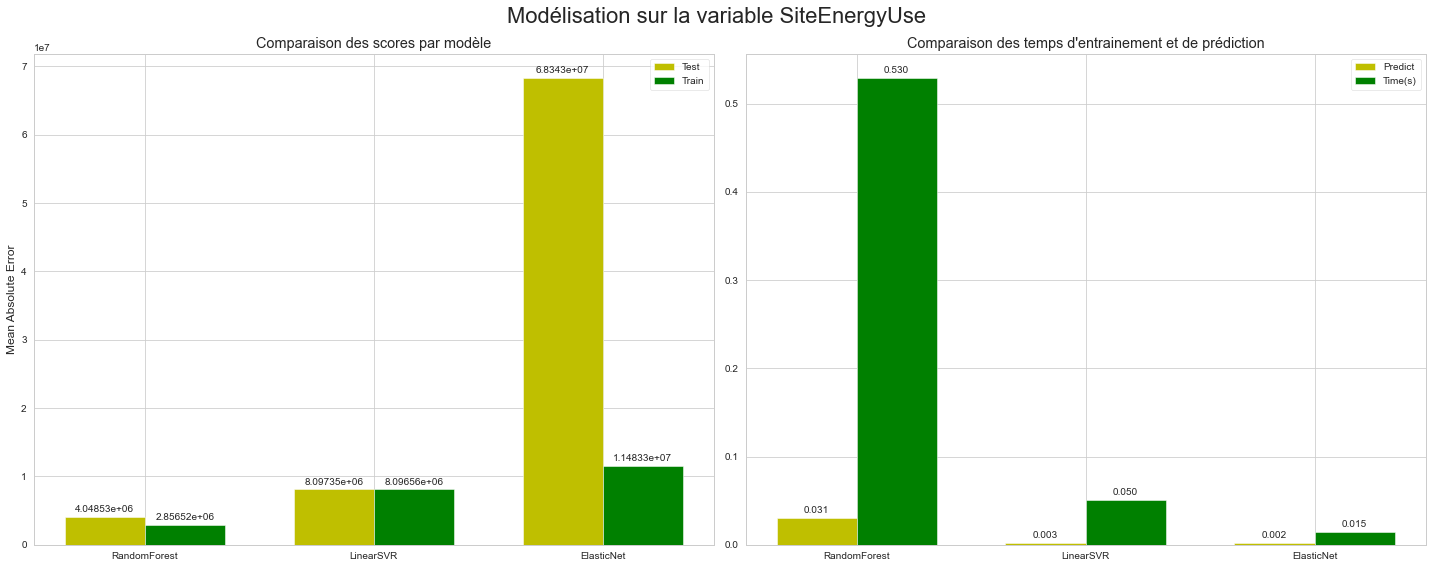

In [967]:
from cProfile import label
from time import time
from turtle import color, width


SEU_final_metrics_compare = SEU_final_metrics_compare[SEU_final_metrics_compare.index != 'LinearRegression']
x = np.arange(len(SEU_final_metrics_compare.index))
width = 0.35

fig, ax = plt.subplots(1,2,figsize=(20,8),sharey=False ,sharex=False)

scores1 = ax[0].bar(x - width/2, -1*SEU_final_metrics_compare['mean_test_neg_mean_absolute_error'],width ,color='y', label='Test' )
scores2 = ax[0].bar(x + width/2, -1*SEU_final_metrics_compare['mean_train_neg_mean_absolute_error'],width ,color='g', label='Train' )
ax[0].set_ylabel('Mean Absolute Error')
ax[0].set_title('Comparaison des scores par modèle')
ax[0].set_xticks(x)
ax[0].set_xticklabels(SEU_final_metrics_compare.index)
ax[0].legend()
ax[0].bar_label(scores1,padding=3)
ax[0].bar_label(scores2,padding=3)

times1 = ax[1].bar(x - width/2,SEU_final_metrics_compare['mean_score_time'],width,color='y',label='Predict')
times2 = ax[1].bar(x + width/2,SEU_final_metrics_compare['mean_fit_time'],width,color='g',label='Time(s)')
ax[1].set_xticks(x)
ax[1].set_title("Comparaison des temps d'entrainement et de prédiction")
ax[1].set_xticklabels(SEU_final_metrics_compare.index)
ax[1].legend()
ax[1].bar_label(times1,padding=3,fmt='%.3f')
ax[1].bar_label(times2,padding=3,fmt='%.3f')

plt.suptitle("Modélisation sur la variable SiteEnergyUse",fontsize=22)
fig.tight_layout()

plt.show()

Remarque:  Avec la projection graphique ci-dessus;

    - on constate que le modèle RandomForestRegressor offre le meilleur compromis score / temps. 
    Il est en effet meilleur en terme de score MAE et également bien plus rapide que les autres modèles.

 => <strong>Le modèle retenu pour la modélisation de la variable SiteEnergyUse est donc le modèle RandomForestRegressor.</strong> 
 
 Nous pouvons à présent visualiser l'impact des hyperparamètres de la GridSearch :

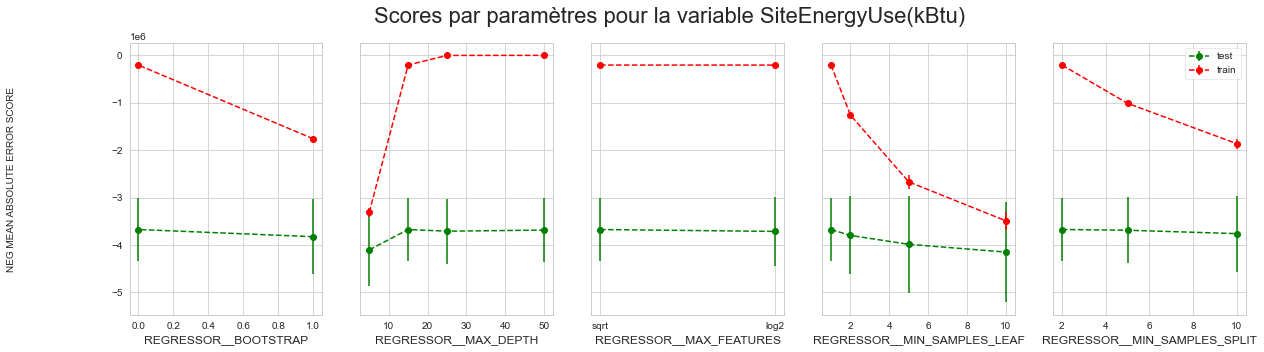


Rappel des meilleurs paramètres :
{'regressor__bootstrap': False, 'regressor__max_depth': 15, 'regressor__max_features': 'sqrt', 'regressor__min_samples_leaf': 1, 'regressor__min_samples_split': 2}


In [968]:
plot_search_results(SEU_rfr_model.named_steps['grid_search_rfr'],title='SiteEnergyUse(kBtu)')

In [969]:
preprocessing

<module 'sklearn.preprocessing' from 'd:\\COURS LP DATA RIZZA\\python anaconda 3\\lib\\site-packages\\sklearn\\preprocessing\\__init__.py'>

Transformer numeric (type RobustScaler) does not provide get_feature_names. Will return input column names if available


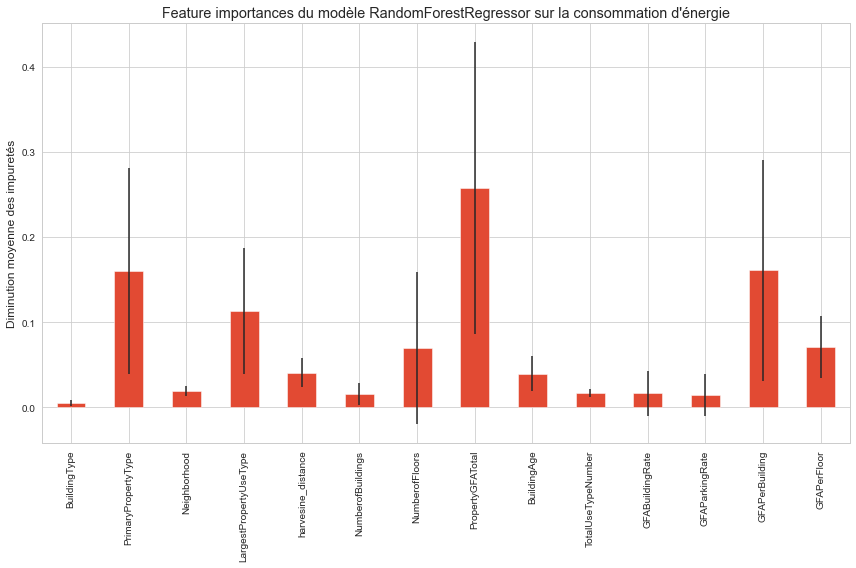

In [970]:
#Graphique des features imortance sur la consommation d'énergies (TEST)

feature_importance = SEU_rfr_model.named_steps['grid_search_rfr'].best_estimator_.regressor_.feature_importances_ 
features_names = get_feature_names(SEU_rfr_model.named_steps['preprocessing'])
std = np.std([
    tree.feature_importances_ for tree in SEU_rfr_model.named_steps['grid_search_rfr'].best_estimator_.regressor_], axis=0)
df_feature_importance = pd.Series(feature_importance, index=features_names)

fig, ax = plt.subplots(figsize=(12,8))
df_feature_importance.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances du modèle RandomForestRegressor sur la consommation d'énergie")
ax.set_ylabel("Diminution moyenne des impuretés")
fig.tight_layout()

### 6.Test des modèles sélectionnées

Nous pouvons à présents tester les modèles sélectionnées sur nos données test et vérifier nos perfomances 

In [971]:
import matplotlib.pyplot as plt

In [972]:
def metrics_model(y_true,y_pred):
    y_true,y_pred = np.array(y_true),np.array(y_pred)
    diff = y_true - y_pred
    mae = np.mean(abs(diff))
    r2 = 1-(sum(diff**2)/sum((y_true-np.mean(y_true))**2))
    dict_metrics = {"Metrique":["MAE","R2"],"Résultats":[mae,r2]}
    df_metrics = pd.DataFrame(dict_metrics)
    return df_metrics

In [973]:
def plot_pred_true(y_true,y_pred,color=None,title=None):
    X_plot = [y_true.min(),y_true.max()]
    fig=plt.figure(figsize=(12, 8))
    plt.scatter(y_true,y_pred,color=color,alpha=0.6)
    plt.plot(X_plot,X_plot,color='r')
    plt.xlabel("Valeurs réelles")
    plt.ylabel("Valeurs prédites")
    plt.title("Valeurs prédites VS valeurs réelles | Variables {}".format(title),fontsize=18)
    plt.show()

#### 6.2 Prédiction des consommations d'énergie:

In [974]:
#start_time = time.time()

SEU_pred = SEU_rfr_model.predict(X_test)

#print("Temps d'execution du modèle:{:.2}(s)".format((time.time()-start_time)))

In [975]:
#Calcule des métriques pour les consommations d'énergies :

SEUmetrics = metrics_model(Y_test["SiteEnergyUse(kBtu)"],SEU_pred)
SEUmetrics

,Metrique,Résultats
0,MAE,5.602080e+06
1,R2,1.739767e-01


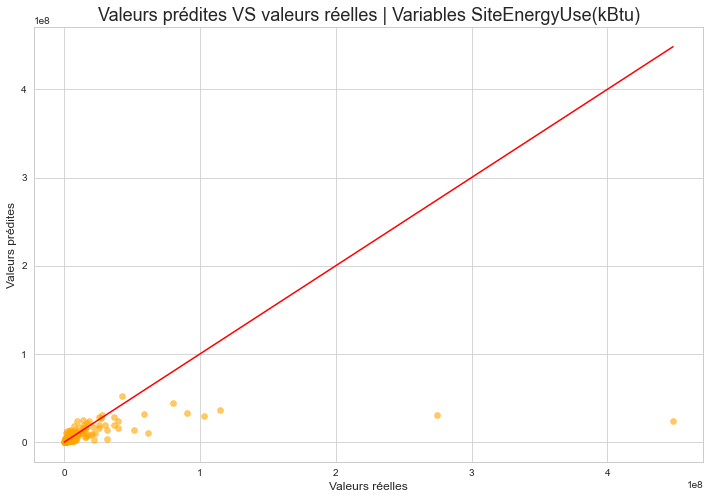

In [976]:
#Affichage des valeurs prédites vs valeurs réelles : 

plot_pred_true(Y_test["SiteEnergyUse(kBtu)"],SEU_pred,color='orange',title="SiteEnergyUse(kBtu)")

Remarque :

- Nous avons ici , le même problématique que pour la variable des émisions de CO2 (TotalGHG) : Le modèle est permformant à l'entrainement("Train") mais n'arrivent pas à généraliser le jeu de "Test"

- Nous pouvons regarder les <strong> "écarts de prédiction en fonction du type de bâtiment"</strong> pour vérifier si des écarts sont plus importants dans certaines catégories :

In [977]:
final_SEU_test = pd.concat([X_test,Y_test],axis=1)

final_SEU_test['SEU_pred'] = SEU_pred
compare_final_SEU_test = final_SEU_test = final_SEU_test.groupby(by='BuildingType').mean()



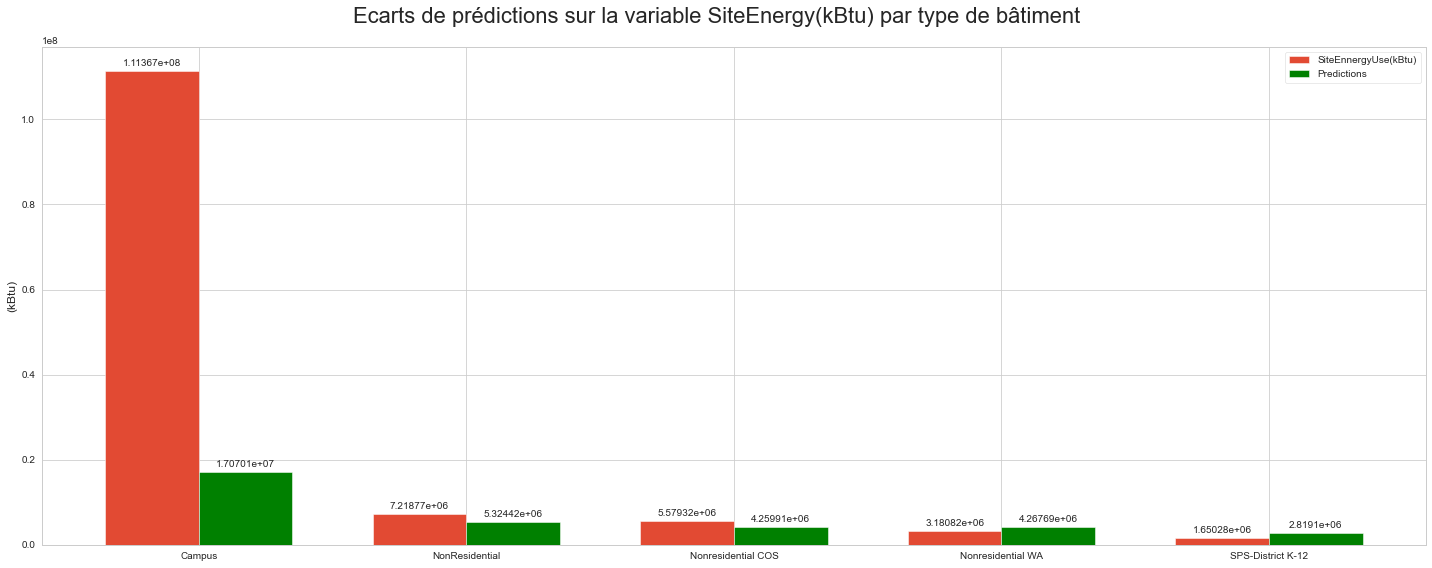

In [978]:
x = np.arange(len(compare_final_SEU_test.index))
width = 0.35

fig,ax = plt.subplots(figsize=(20, 8),sharey=False,sharex=False)

scores1 = ax.bar(x-width/2 ,compare_final_SEU_test['SiteEnergyUse(kBtu)'],width,label='SiteEnnergyUse(kBtu)')
scores2 = ax.bar(x+width/2 ,compare_final_SEU_test['SEU_pred'],width,color='green',label='Predictions')

ax.set_ylabel('(kBtu)')
ax.set_xticks(x)
ax.set_xticklabels(compare_final_SEU_test.index)
ax.legend()
ax.bar_label(scores1,padding=3)
ax.bar_label(scores2,padding=3)

plt.suptitle("Ecarts de prédictions sur la variable SiteEnergy(kBtu) par type de bâtiment",fontsize=22)
fig.tight_layout()

plt.show()

Remarque : 

- Nous remarquons que l'écart est très important sur la catégorie " Campus" qui est faiblement représentée dans le jeu de données mais qui  présente les plus grandes consommations. 

-----------------------

### 7) Influance du score "ENERGY STAR"

Le score ENERGY STAR fournit un aperçu complet de la performance énergétique d'un bâtiment, en tenant compte des actifs physiques, des opérations et du comportement des occupants du bâtiment. Il est exprimé sur une échelle de 1 à 100 facile à comprendre : plus le score est élevé, meilleure est la performance énergétique du bâtiment.

Ce score permet de réaliser plusieurs actions :

- Évaluer les données énergétiques réelles facturées,
- Normaliser pour l'activité commerciale (heures, travailleurs, climat),
- Comparer les bâtiments à la population nationale,
- Indiquer le niveau de performance énergétique.

Nous allons donc évaluer si <strong>l'ENERGY STAR</strong> à un impact significatif sur les performances de notre modélisation.

In [979]:
#Ajout de la variable à nos variables X 

X['energystar_score'] = energystar_score

#Ajout de la vaiable dans les variables numériques du "preprocessor"

numeric_features.append('energystar_score')

In [980]:
#Filtrage des données ayant un Energy Star Score :

X = X[X['energystar_score'].isnull()==False]
Y= Y[Y.index.isin(list(X.index))]

Phase d'entrainement pour les modèles de RandomForestRegressor avec ou sans "Energy Star" sur le même taille d'échantillonage (pour une même base de comparaison):

- Phase 1 :RandomForestRegressor sans Energy Star Score
- Phase 2 :RandomForestRegressor avec Energy Star Score

In [981]:
#Phase 1:
X3 = X
Y4 = Y

In [982]:
#Phase 1:
X4 = X3.drop(['energystar_score'],axis=1)

In [983]:
numeric_features.remove('energystar_score')

In [984]:
#Phase 1:
X4_train,X4_test,Y4_train,Y4_test = train_test_split(X4,Y4,test_size=0.2,random_state=42)
#Random_state nécessaire  = rélancer l"échantillons ici 

print("Entrainement:{} lignes,\nTest:{} lignes.\n".format(X4_train.shape[0],X4_test.shape[0]))

Entrainement:796 lignes,
Test:199 lignes.



In [985]:
#Phase 1: RandomForestRegressor

rfr_grid_cv_eStar1 = Pipeline([
    ('preprocessor',preprocessor),
    ('grid_search_rfr_eStar',GridSearchCV(TransformedTargetRegressor(
        regressor=RandomForestRegressor(),
        func=np.log,
        inverse_func=np.exp),
        param_grid=param_rfr,
        cv=5,
        scoring=('r2','neg_mean_absolute_error'),
        refit='neg_mean_absolute_error',
        n_jobs = -1))])

GHG_rfr_model_eStar1 = rfr_grid_cv_eStar1.fit(X4_train,Y4_train['TotalGHGEmissions'])
GHG_rfr_results_eStar1 = model_scores(GHG_rfr_model_eStar1,'grid_search_rfr_eStar')

Default parameter min_samples_leaf will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327
Default parameter smoothing will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327


Meilleur score MAE : -114.621
Meilleur Score R2 : 0.538
Meilleurs paramètres : {'regressor__bootstrap': False, 'regressor__max_depth': 25, 'regressor__max_features': 'log2', 'regressor__min_samples_leaf': 1, 'regressor__min_samples_split': 2}
Temps moyen d'entrainement : 483.37s


In [986]:
#Phase 1:
GHG_pred_estars1 = GHG_rfr_model_eStar1.predict(X4_test)

In [987]:
#Phase 1:
GHGmetrics4 = metrics_model(Y4_test['TotalGHGEmissions'],GHG_pred_estars1)
GHGmetrics4

,Metrique,Résultats
0,MAE,136.939977
1,R2,0.468547


In [988]:
GHGmetrics4['Sans Energy Star +'] = GHGmetrics4['Résultats']

In [989]:
GHGmetrics5 = GHGmetrics4.drop(["Résultats"],axis=1)

In [990]:
#Phase 2:
numeric_features.append('energystar_score')

In [991]:
#Phase 2:
numeric_features

['harvesine_distance',
 'NumberofBuildings',
 'NumberofFloors',
 'PropertyGFATotal',
 'BuildingAge',
 'TotalUseTypeNumber',
 'GFABuildingRate',
 'GFAParkingRate',
 'GFAPerBuilding',
 'GFAPerFloor',
 'energystar_score']

- Modèle RandomForestRegressor - avec EnergyStarScore

In [992]:
X_train,X_test,Y_train,Y_test = train_test_split(X,Y,test_size=0.2,random_state=42)
#Random_state nécessaire  = rélancer l"échantillons ici 

print("Entrainement:{} lignes,\nTest:{} lignes.\n".format(X_train.shape[0],X_test.shape[0]))

Entrainement:796 lignes,
Test:199 lignes.



In [993]:
rfr_grid_cv_eStar = Pipeline([
    ('preprocessor',preprocessor),
    ('grid_search_rfr_eStar',GridSearchCV(TransformedTargetRegressor(
        regressor=RandomForestRegressor(),
        func=np.log,
        inverse_func=np.exp),
        param_grid=param_rfr,
        cv=5,
        scoring=('r2','neg_mean_absolute_error'),
        refit='neg_mean_absolute_error',
        n_jobs = -1))])

GHG_rfr_model_eStar = rfr_grid_cv_eStar.fit(X_train,Y_train['TotalGHGEmissions'])
GHG_rfr_results_eStar = model_scores(GHG_rfr_model_eStar,'grid_search_rfr_eStar')

Default parameter min_samples_leaf will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327
Default parameter smoothing will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327


Meilleur score MAE : -112.977
Meilleur Score R2 : 0.509
Meilleurs paramètres : {'regressor__bootstrap': False, 'regressor__max_depth': 50, 'regressor__max_features': 'sqrt', 'regressor__min_samples_leaf': 1, 'regressor__min_samples_split': 2}
Temps moyen d'entrainement : 325.89s


- Calcule des métriques  : Avec ou  Sans EnergyStarScore (échantillon de même taille//pour avoir une même base de comparaison) + Modèle sans EnergyStarScore( originel)

In [994]:
GHG_rfr_model = rfr_grid_cv.fit(X_train,Y_train['TotalGHGEmissions'])
GHG_rfr_results = model_scores(GHG_rfr_model,'grid_search_rfr')

Default parameter min_samples_leaf will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327
Default parameter smoothing will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327


Meilleur score MAE : -113.296
Meilleur Score R2 : 0.495
Meilleurs paramètres : {'regressor__bootstrap': False, 'regressor__max_depth': 25, 'regressor__max_features': 'log2', 'regressor__min_samples_leaf': 1, 'regressor__min_samples_split': 2}
Temps moyen d'entrainement : 338.83s


In [995]:
import time 
start_time = time.time()

GHG_pred = GHG_rfr_model.predict(X_test)

print("Temps d'éxecution du modèle:{:.2} (s)".format((time.time()-start_time)))

Temps d'éxecution du modèle:0.081 (s)


In [996]:
GHGmetrics = metrics_model(Y_test['TotalGHGEmissions'],GHG_pred)
GHGmetrics

,Metrique,Résultats
0,MAE,135.098099
1,R2,0.472134


In [997]:
GHG_pred_star = GHG_rfr_model_eStar.predict(X_test)

#Calcul des métriques pour les émissions de CO2: 

GHGmetricsESS = metrics_model(Y_test['TotalGHGEmissions'],GHG_pred_star)

GHGmetrics = GHGmetrics.rename(columns={"Résultats":"Sans Energy Star"})

GHGmetrics['Avec Energy Star +'] = GHGmetricsESS['Résultats']

GHGmetrics

,Metrique,Sans Energy Star,Avec Energy Star +
0,MAE,135.098099,133.237358
1,R2,0.472134,0.510008


In [998]:
#Ici nous allons comparer les metrics avec ou sans le Energy Star Score sur le même échantillons de "bâtiment de construction" pour avoir un point de comparaison entre les modèles :
A1 = GHGmetrics5
B1 = GHGmetrics

In [999]:
#Echantillons de comparaison ( "bâtiment de construction") sans "energystar_score" pour le modèle RandomForestRegressor - Résultats des métrics R2 and MAE:
A1

,Metrique,Sans Energy Star +
0,MAE,136.939977
1,R2,0.468547


In [1000]:
#Ici nous allons comparer les metrics avec ou sans le Energy Star Score sur le même échantillons de "bâtiment de construction" pour avoir un point de comparaison entre les deux méthodes
#sur le meilleur sélectionné "RandomForestRegressor" : Avec Energy Star  + |Sans Energy Star +
pd.merge(B1,A1, on="Metrique")

,Metrique,Sans Energy Star,Avec Energy Star +,Sans Energy Star +
0,MAE,135.098099,133.237358,136.939977
1,R2,0.472134,0.510008,0.468547


Remarque : 

 - Le coefficient de détermination (R2) :  Avec ESS > Sans ESS
 - <strong>Selon le MAE : Avec ESS = Sans ESS || Quasi - identique</strong>

 - => Globalement selon nos métrics (MAE) : les résultats du modèle du RandomForestRegressor sont globalement identiques avec un légère avantage pour le modèle sans le ESS.

 Note : ESS = Energy Star Score

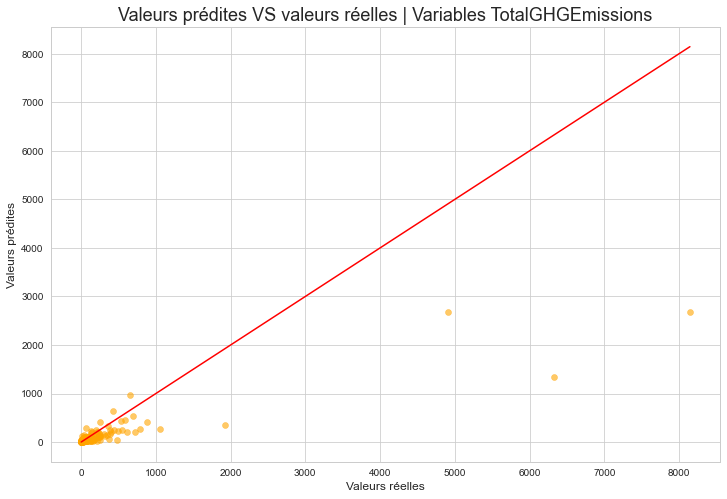

In [1001]:
#Affichage des valeurs réelle | Valeurs réelles pour émissions de CO2 : 

plot_pred_true(Y_test['TotalGHGEmissions'],GHG_pred_star,color='orange',title='TotalGHGEmissions')

---------------------

#### Conclusion 

Afin de répondre à l'ensemble de notre problématique concernant les émissions de CO2 et la consommation d'énergie ainsi que la pertinence de l'EnergyStarScore sur les différentes constructions non résidentielles :

 - Nous avons réalisé différents des modèles de machine learning : Une régression linéaire multivariée, un SVR ,une ElastingNET et un RandomForestRegressor. 

 - Les résultats obtenus après différentes features engineering et selon les critères de comparaison mise en place : Coefficient de détermination et <strong>MAE (l'erreur absolue moyenne ( EMA ->Fr ))</strong>
        nous montre que : le modèle le plus efficace est <strong>le RandomForestRegressor</strong> loin devant tous les autres modèles ! 

 - Les prédictions réalisées sur nos 2 critères (CO2 et Energie) sont globalement correctes [Hormis pour certaines valeurs très grande -> tirée probablement par le feature:"type bâtiment : les campus" entre valeurs prédites || réelle] 

=>  * En ce qui concerne , la prise en compte du critère:<strong> "Energy Star Score" </strong> à travers le meilleur modèle (RandomForestRegressor) , nous indiquent que <strong>ce score n'importe pas de changement significative à notre modèle</strong> : les métrics nous indiquent que les modèles avec ou sans Energy Star Score sont  globalement identiques (même si un petit peu inf au modèle sans le critère EStarScore) .
    
    Or, la prise en compte de ce critère dans nos différents modèles sachant que celle-ci a un cout significative pour la ville n'est pas du tout pertinente en regardant le rapport COUT//Bénefices .